In [1]:
! pip install -q split-folders
! pip install -q easyocr
! pip install -q xmltodict
! pip install -q gdown
! pip install -q GPUtil

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# Giải nén data đã chuẩn bị và cài đặt các thư viện

In [2]:
! gdown 1D7z8jWR-FgAwfg0QLgLjDg6eViDNVXyl

Downloading...
From (original): https://drive.google.com/uc?id=1D7z8jWR-FgAwfg0QLgLjDg6eViDNVXyl
From (redirected): https://drive.google.com/uc?id=1D7z8jWR-FgAwfg0QLgLjDg6eViDNVXyl&confirm=t&uuid=b945cf7f-a07e-494c-8615-01989232cf7c
To: /content/dataset.zip
100% 372M/372M [00:06<00:00, 55.4MB/s]


In [4]:
! git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 17067, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 17067 (delta 22), reused 23 (delta 8), pack-reused 17022 (from 1)
Receiving objects: 100% (17067/17067), 15.69 MiB | 28.44 MiB/s, done.
Resolving deltas: 100% (11716/11716), done.


In [5]:
import zipfile
with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [6]:
! rm -rf dataset.zip

In [7]:
from matplotlib import patches as mpatches
from matplotlib import image as mpimg
from matplotlib import pyplot as plt
import matplotlib
import torch
from timeit import default_timer as timer
from numba import cuda
from GPUtil import showUtilization as gpu_usage
from tqdm.auto import tqdm
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from pathlib import Path
import copy
import PIL
import easyocr
import splitfolders
import random as rnd
import xml.etree.ElementTree as ET
import glob
import xmltodict
import pandas as pd
import time
import uuid
import cv2
import numpy as np
import os
import yaml
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

pd.options.mode.chained_assignment = None  # default='wa

In [8]:
"""
Mỗi hình ảnh sẽ có một tệp txt mô tả
"""

img_names=[]
annotations=[]
for dirname, _, filenames in os.walk("dataset/"):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]=="jpg":
            img_names.append(filename)
        elif os.path.join(dirname, filename)[-3:]=="txt":
            annotations.append(filename)

print(len(img_names), len(annotations))

print(img_names[:10])

5750 5750
['xemay2464_jpg.rf.1884426f2dad2280a31d4a5d18b29567.jpg', 'xemayBigPlate158_jpg.rf.999dc06fb48626a88228936d8b9cf142.jpg', 'boderquandoi14_jpg.rf.696f9becd59ff8829ebc748e2063b5f0.jpg', 'xemayBigPlate44_jpg.rf.cb2c4bbf3521f6bb914b99569ca62b84.jpg', '0007870724402b51_jpg.rf.6375e00a542721e022f52353794e893c.jpg', 'xemay719_jpg.rf.583bba122f71e62696a6db9b0044b326.jpg', 'CarLongPlateGen2960_jpg.rf.dadec8e1274853535636f5c4d8d732c2.jpg', 'xemay1861_jpg.rf.8ed87a37b2e610d5ea830b68187b8a5d.jpg', 'CarLongPlateGen1459_jpg.rf.654baa00ccd8ad32467c7ec1c77886f7.jpg', 'CarLongPlateGen130_jpg.rf.73bb3feb2acc1db93049d8d3323042e1.jpg']


In [16]:
# Đường dẫn tới thư mục chứa các file annotations
annotations_path = "dataset/labels"

# Tạo một danh sách để lưu các dữ liệu đọc được
data = []

# Duyệt qua các file trong thư mục annotations
for file_name in os.listdir(annotations_path):
    if file_name.endswith(".txt"):  # Chỉ xử lý file .txt
        file_path = os.path.join(annotations_path, file_name)
        with open(file_path, "r") as f:
            lines = f.readlines()
            for line in lines:
                class_id, x, y, width, height = map(float, line.strip().split())
                # Thêm file_name để tham chiếu về sau
                file_name = file_name.split('.txt')[0]+'.jpg'
                data.append([file_name, class_id, x, y, width, height])

# Chuyển dữ liệu thành DataFrame
columns = ["file_name", "class_id", "x_pos", "y_pos", "frame_width", "frame_height"]
df = pd.DataFrame(data, columns=columns)

# Hiển thị DataFrame
df

,file_name,class_id,x_pos,y_pos,frame_width,frame_height
0,CarLongPlateGen1499_jpg.rf.36cfd6e1c13b4104754...,0.0,0.540625,0.473438,0.211719,0.096094
1,CarLongPlateGen1417_jpg.rf.80840a60e9d561605b8...,0.0,0.710156,0.681250,0.146875,0.062500
2,CarLongPlate798_jpg.rf.f1d845d3f7a190d44c8c0af...,0.0,0.350781,0.711719,0.209375,0.074219
3,CarLongPlateGen1683_jpg.rf.3a380488053ef262c6b...,0.0,0.524219,0.564844,0.187500,0.086719
4,CarLongPlateGen1739_jpg.rf.ca6faf6facebe53c9f7...,0.0,0.556250,0.596094,0.209375,0.082031
...,...,...,...,...,...,...
6205,CarLongPlateGen1418_jpg.rf.1f46cf12f38c6e7ac5e...,0.0,0.542969,0.602344,0.221094,0.096094
6206,CarLongPlateGen1449_jpg.rf.daec3f052f108ae6654...,0.0,0.478125,0.330469,0.211719,0.113281
6207,cropquandoi23_jpg.rf.9247d0974792d449c379b9ba5...,0.0,0.225781,0.466406,0.204687,0.076563
6208,xemay1918_jpg.rf.786abf7e07a0c5c81395eb39337a4...,0.0,0.478125,0.459375,0.139063,0.165625


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6210 entries, 0 to 6209
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   file_name     6210 non-null   object 
 1   class_id      6210 non-null   float64
 2   x_pos         6210 non-null   float64
 3   y_pos         6210 non-null   float64
 4   frame_width   6210 non-null   float64
 5   frame_height  6210 non-null   float64
dtypes: float64(5), object(1)
memory usage: 291.2+ KB


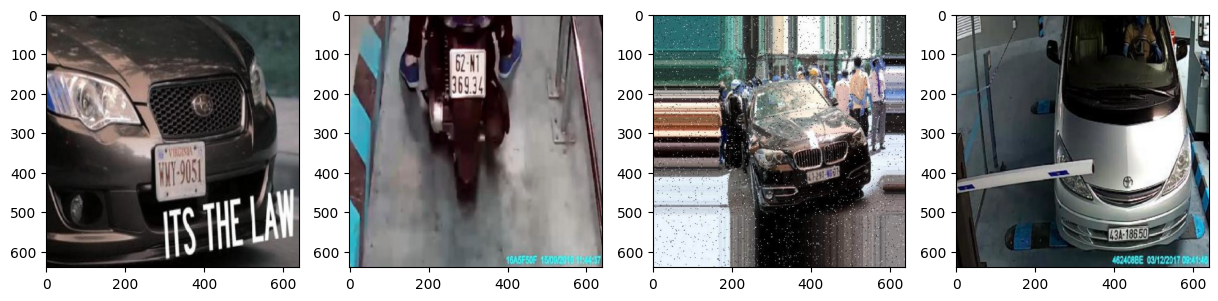

In [11]:
# Hiển thị bất kỳ 4 ảnh lưu tại đường dẫn sau
def showRandomImage(photos):
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))
    random_photos = rnd.sample(photos, 4)
    for plot_index, image_path in enumerate(random_photos):
        for index, file in enumerate(df.file_name):
            # Lấy ra thông tin của ảnh (tọa độ chéo trên, chéo dưới)
            if image_path.split("/")[-1] == file:
                information = list(df.iloc[index, -4:])
                # print(information)
                image = cv2.imread(image_path)
                ax[plot_index].imshow(image)
    plt.show()

photo_path = "dataset/images/*.jpg"
photo_list = glob.glob(photo_path)
showRandomImage(photo_list)


In [12]:
'''
Bộ dataset sẽ di chuyển vào:

- yolov5
  - data
    - Plate_recognition
      - train
        - annotations
        - image
        - labels
      - val
        - annotations
        - image
        - labels
'''
input_folder = Path("dataset")
output_folder = Path("yolov5/data/Plate_recognition")
splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=42,
    ratio=(0.8, 0.2),
    group_prefix=None
)

print("Moving files finished.")

Copying files: 11500 files [00:02, 4924.26 files/s]

Moving files finished.


In [13]:
# YoloV5 yêu cầu một file định dạng .yaml để xác định các class trong lúc train.
# File này chỉ định các đường dẫn tới dữ liệu train, test, và validation.

# Tạo file YAML
classes = ['0']
yaml_file = 'yolov5/data/plates.yaml'

yaml_data = dict(
    path="data/Plate_recognition",  # Đường dẫn tới thư mục chứa dataset
    train="train",  # Đường dẫn tới thư mục train trong dataset
    val="val",  # Đường dẫn tới thư mục validation trong dataset
    nc=len(classes),  # Số lượng class cần dự đoán
    names=classes  # Tên các class
)

with open(yaml_file, 'w') as f:
    yaml.dump(yaml_data, f, explicit_start=True, default_flow_style=False)

"""
Cấu trúc file YAML sẽ như sau:
---
names:
- license
nc: 1
path: data/Plate_recognition
train: train
val: val
"""

'\nCấu trúc file YAML sẽ như sau:\n---\nnames:\n- license\nnc: 1\npath: data/Plate_recognition\ntrain: train\nval: val\n'

# Train model   

In [18]:
def free_gpu_cache() -> None:
    print("Initial GPU Usage")
    gpu_usage()

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  1% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  2% |  1% |


In [20]:
start_time = timer()

!python yolov5/train.py --workers 2 --img 640 --batch 32 --epochs 5 --data yolov5/data/plates.yaml --weights yolov5s.pt
# --img ảnh đầu vào kích cỡ là 640
# --batch batch_size là 16
# --epochs 100
# --data đường dẫn đến file yaml
# --weight yolov5s.pt mặc định
# --device 0 chọn CPU/ cuda nếu có Nvidia

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-26 02:12:10.803784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-26 02:12:10.823263: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-26 02:12:10.829102: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visua

cat: /kaggle/working/yolov5/data/Plate_recognition/train/annotations/00009e5b390986a0_jpg.rf.c53176323c9ae72e3787d20f1e4a5f95.txt: No such file or directory


# Predict


In [25]:

## load model
model = torch.hub.load('ultralytics/yolov5', 'custom',
                       path='/content/yolov5/runs/train/exp2/weights/best.pt', force_reload=True)

## chọn ngôn ngữ của biển số xe
reader = easyocr.Reader(['en'])


def get_plates_xy(frame: np.ndarray, labels: list, row: list, width: int, height: int, reader: easyocr.Reader) -> tuple:
    '''Lấy kết quả từ easyOCR cho mỗi frame(hình ảnh), trả lại tọa độ bounding box '''

    x1, y1, x2, y2 = int(row[0]*width), int(row[1]*height), int(row[2]
                                                                * width), int(row[3]*height)  # BBOx coordniates
    plate_crop = frame[int(y1):int(y2), int(x1):int(x2)]
    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)  # BBox
    # , paragraph="True", min_size=50)
    ocr_result = reader.readtext(np.asarray(
        plate_crop), allowlist='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')

    return ocr_result, x1, y1


def detect_text(i: int, row: list, x1: int, y1: int, ocr_result: list, detections: list, yolo_detection_prob: float = 0.3) -> list:

    if row[4] >= yolo_detection_prob:  # discard predictions below the value
        if (len(ocr_result)) > 0:
            for item in ocr_result:
                detections[i][0] = item[1]
                detections[i][1] = [x1, y1]
                detections[i][2] = item[2]

    return detections


def is_adjacent(coord1: list, coord2: list) -> bool:
    MAX_PIXELS_DIFF = 50

    if (abs(coord1[0] - coord2[0]) <= MAX_PIXELS_DIFF) and (abs(coord1[1] - coord2[1]) <= MAX_PIXELS_DIFF):
        return True
    else:
        return False


def sort_detections(detections: list, plates_data: list) -> list:
    for m in range(0, len(detections)):
        for n in range(0, len(plates_data)):
            if not detections[m][1] == [0, 0] and not plates_data[n][1] == [0, 0]:
                if is_adjacent(detections[m][1], plates_data[n][1]):
                    if m != n:
                        temp = detections[m]
                        detections[m] = detections[n]
                        detections[n] = temp

    return detections


def delete_old_labels(detections: list, count_empty_labels: list, plates_data: list, frames_to_reset: int = 3) -> tuple:
    for m in range(0, len(detections)):
        if detections[m][0] == 'None' and not count_empty_labels[m] == frames_to_reset:
            count_empty_labels[m] += 1
        elif count_empty_labels[m] == frames_to_reset:
            count_empty_labels[m] = 0
            plates_data[m] = ['None', [0, 0], 0]
        else:
            count_empty_labels[m] = 0

    return plates_data, count_empty_labels


def overwrite_plates_data(detections: list, plates_data: list, plate_lenght=None) -> list:
    if (detections[i][2] > plates_data[i][2] or detections[i][2] == 0):
        if plate_lenght:
            if len(detections[i][0]) == plate_lenght:
                plates_data[i][0] = detections[i][0]
                plates_data[i][2] = detections[i][2]
        else:
            plates_data[i][0] = detections[i][0]
            plates_data[i][2] = detections[i][2]
    plates_data[i][1] = detections[i][1]

    return plates_data

## đường dẫn ảnh
test_photo_path = "/content/yolov5/data/Plate_recognition/train/images/xemayBigPlate78_jpg.rf.6dfa8003f178c00c2e2b240c2049888b.jpg"

results = model(test_photo_path)
detections=np.squeeze(results.render())

labels, coordinates = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]
image = cv2.imread(test_photo_path)
width, height = image.shape[1], image.shape[0]

print(f'Ảnh Rộng, Cao: {width},{height}. Số lượng biển số xe: {len(labels)}')

for i in range(len(labels)):
    row = coordinates[i]
    if row[4] >= 0.6:
        x1, y1, x2, y2 = int(row[0]*width), int(row[1]*height), int(row[2]*width), int(row[3]*height)
        plate_crop = image[int(y1):int(y2), int(x1):int(x2)]
        ocr_result = reader.readtext((plate_crop), paragraph="True", min_size=120, allowlist = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
        text=ocr_result[0][1]
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 6) ## BBox
        cv2.putText(image, f"{text}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 3)
        plt.axis(False)
        plt.imshow((image)[...,::-1])

        print(f'Dự đoán: {i+1}. Trọng số: {row[4]:.2f}, easyOCR Kết quả: {ocr_result}')

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-11-26 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
WARNING ⚠️ NMS time limit 0.550s exceeded


Ảnh Rộng, Cao: 640,640. Số lượng biển số xe: 1
Dự đoán: 1. Trọng số: 0.84, easyOCR Kết quả: [[[[19, 0], [188, 0], [188, 172], [19, 172]], '65P5 9341']]
